In [125]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess
sns.set_palette("rocket")
sns.set_style("dark")

In [144]:
df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")

df["date"] = pd.to_datetime(df["date"])
df.columns=["date","oil"]

mean = df["oil"].mean()
# df["oil"].fillna(mean,inplace=True)
df.dropna(inplace=True)

---

# 1. Time Step & Lag Feature

### 1.1 Time Step Feature + Linear Regression

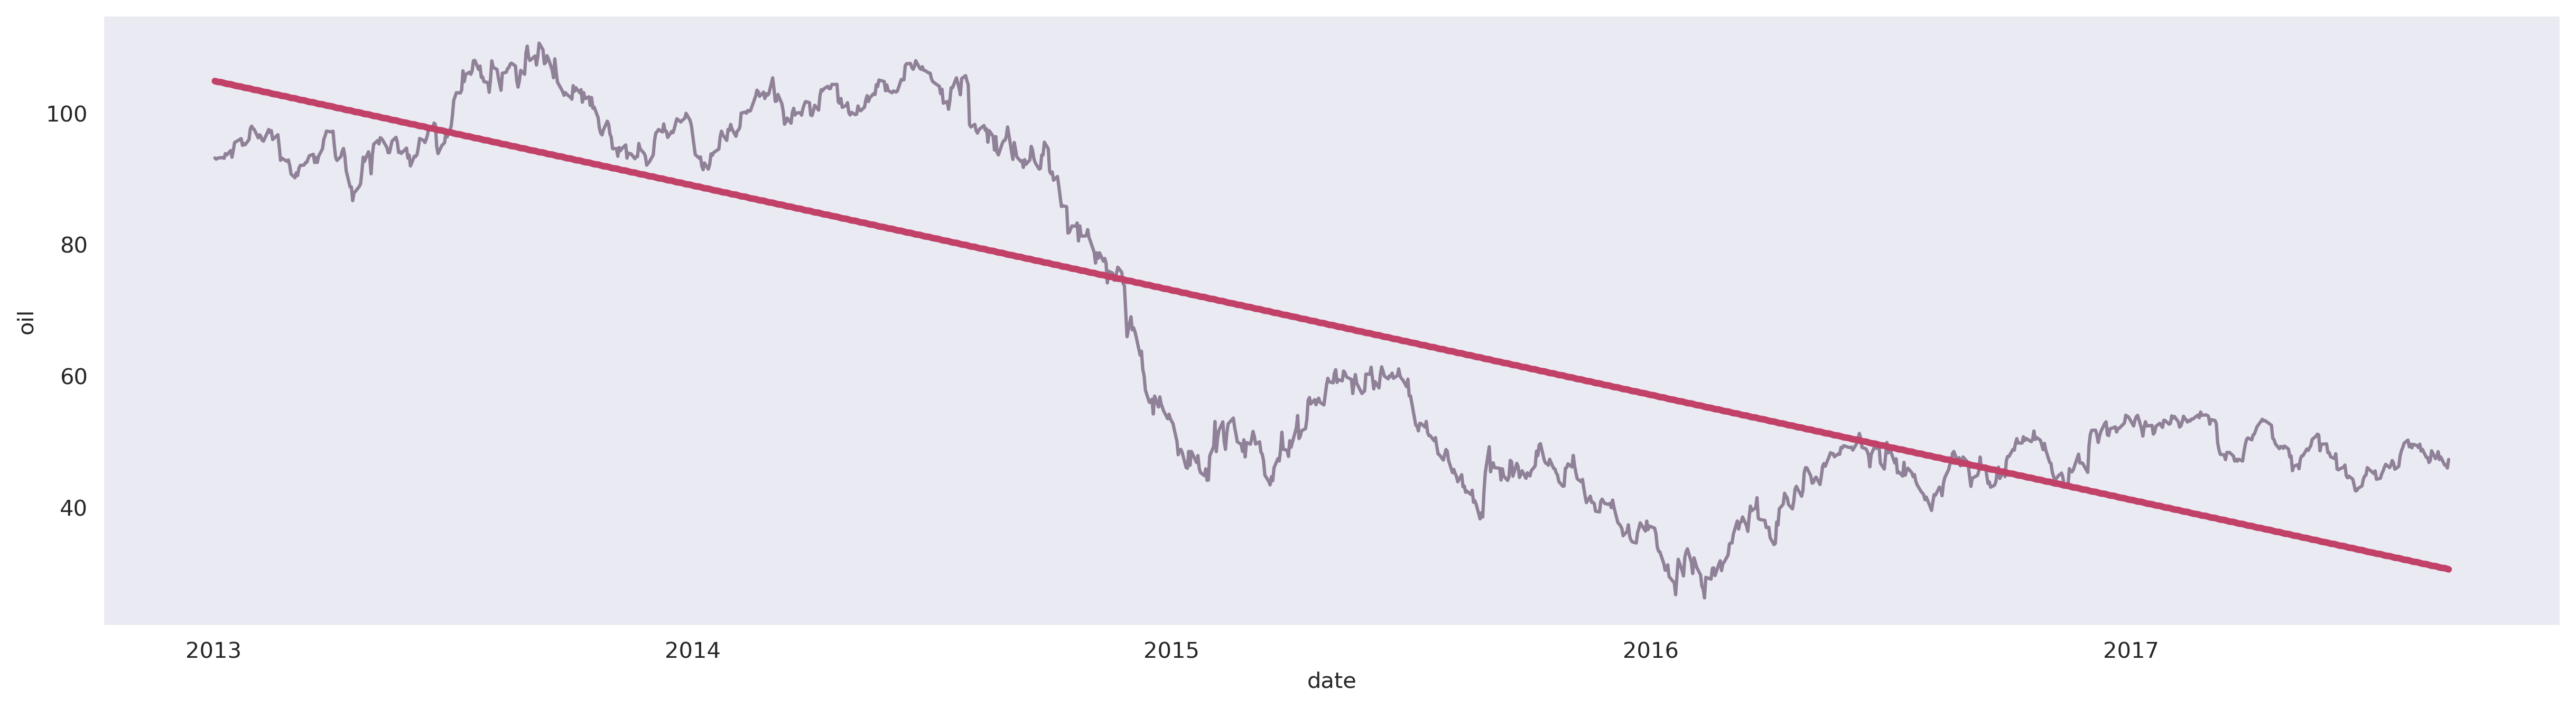

In [122]:
# Time Step
df_time = df.copy()
df_time["time"] = df_time.index
df_time.set_index("date",inplace=True)

X = df_time[["time"]]  # features
y = df_time.oil # target

# Train the model
model = LinearRegression()
model.fit(X, y)
fitted_pred = pd.DataFrame({"sales":model.predict(X)})
fitted_pred.index=df_time.index

plt.figure(figsize=(20,5),dpi=300)
sns.lineplot(x=df_time.index,y=df_time["oil"],alpha=0.5);
sns.lineplot(fitted_pred,palette="flare",linewidth=3,legend=False);

### 1.2 Lag Feature + Linear Regression

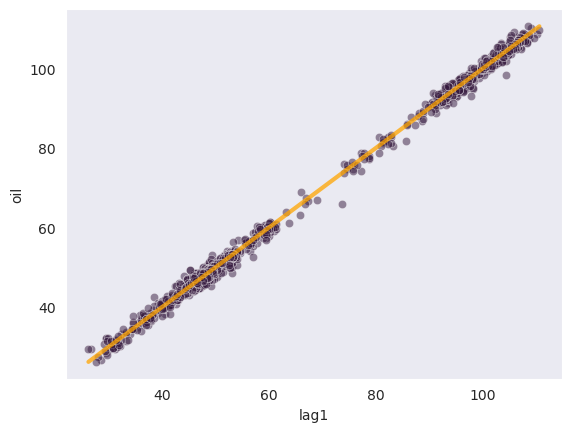

In [110]:
df_lag = df.copy()
df_lag["lag1"] = df["oil"].shift(1) 
df_lag.set_index("date",inplace=True)
df_lag.dropna(inplace=True)

X = df_lag[["lag1"]]  # features
y = df_lag.oil # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# Train the model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

sns.scatterplot(df_lag,y="oil",x="lag1",alpha=0.5)
sns.lineplot(y=y_pred,x=df_lag["lag1"],alpha=0.75,linewidth=3,color='orange');

---

# 2. Creating Moving Average Plot (Trends)

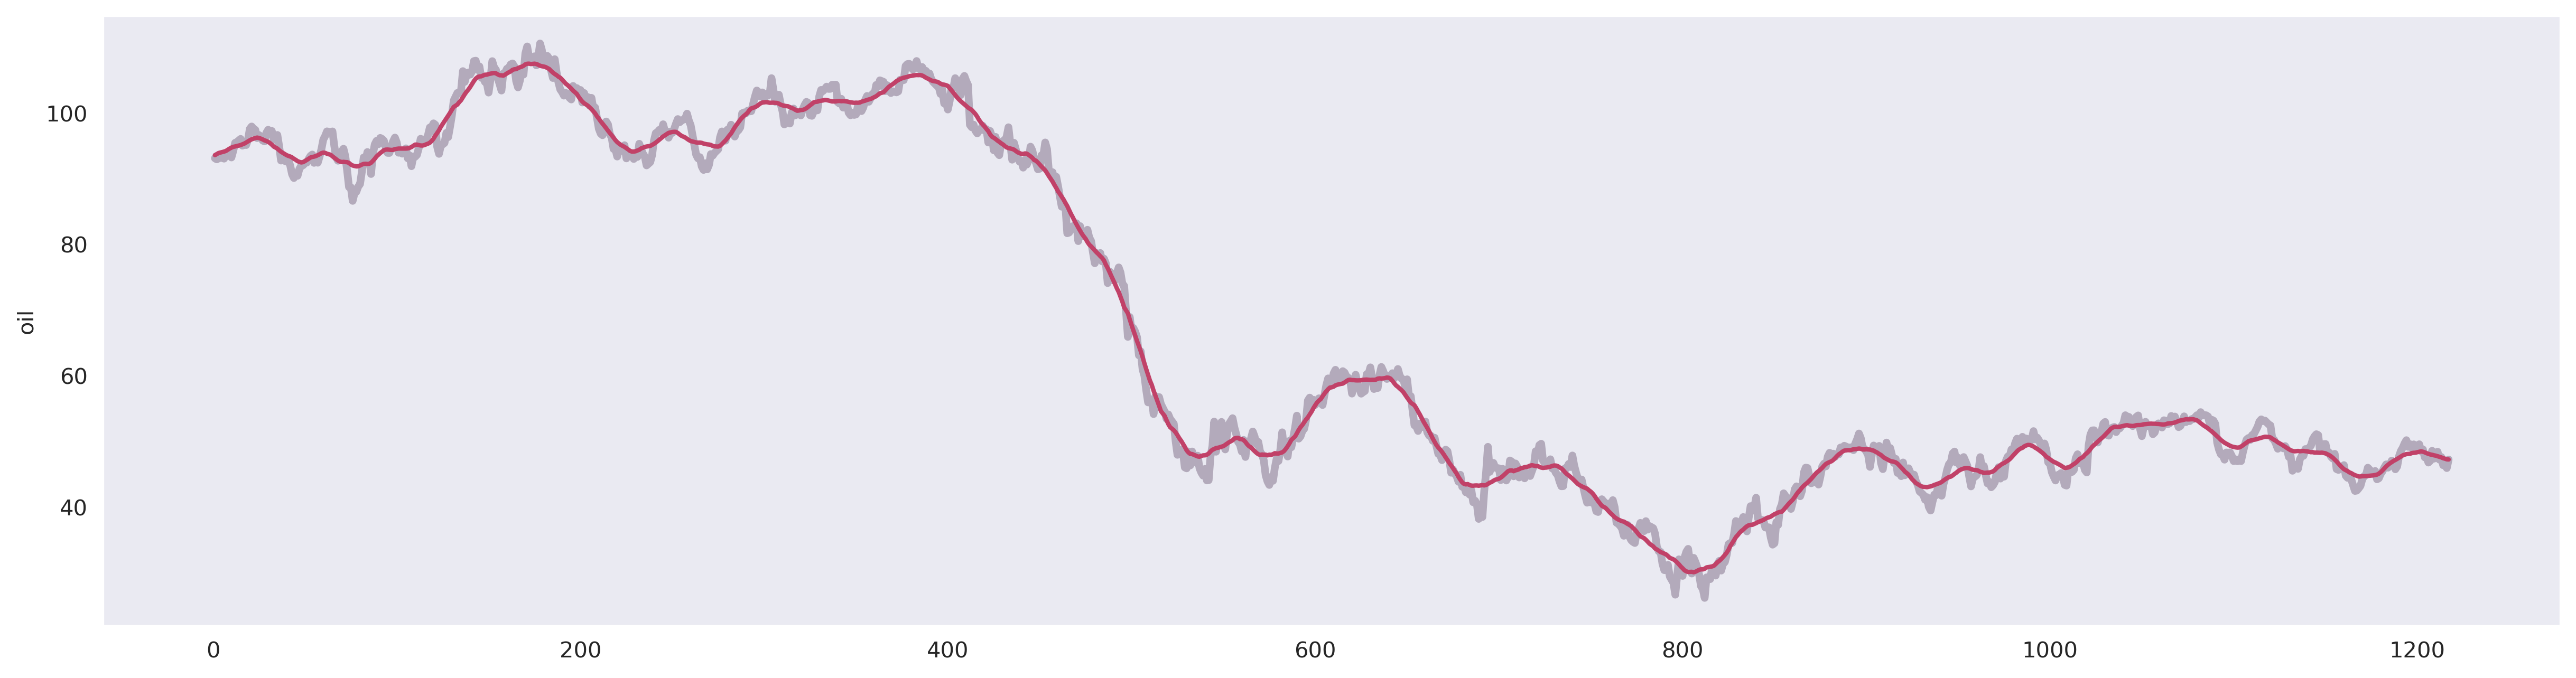

In [121]:
moving_average = df.rolling(
    window=24,        # 24-months window
    center=True,      # puts the average at the center of the window
    min_periods=12,   # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)
plt.figure(figsize=(20,5),dpi=300)
sns.lineplot(x=df.index,y=df["oil"],alpha=0.3,linewidth=3.5);
sns.lineplot(moving_average,palette="flare",linewidth=2,legend=False);

---

# 3. Deterministic Process

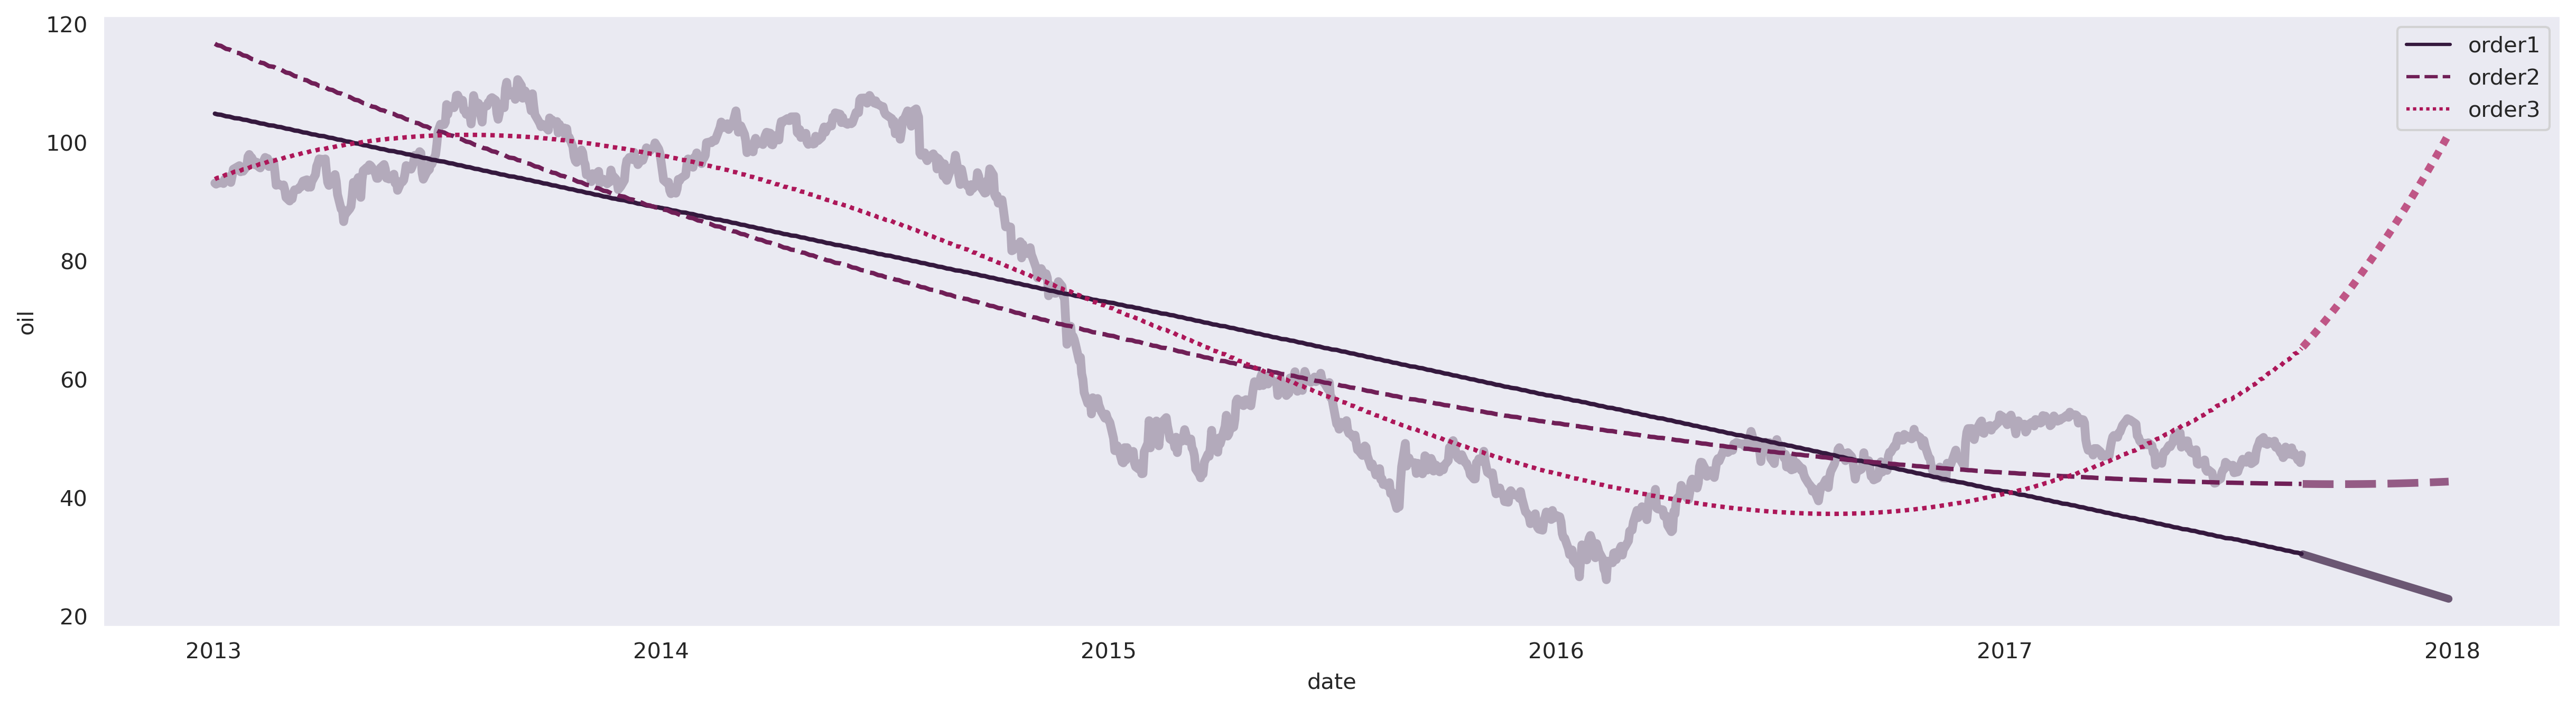

In [210]:
# df.set_index("date",inplace=True)

dp1 = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

dp2 = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
dp3 = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

X1 = dp1.in_sample()
X2 = dp2.in_sample()
X3 = dp3.in_sample()

y = df["oil"]  # the target

# The intercept is the same as the `const` feature from DeterministicProcess. LinearRegression behaves badly with 
# duplicated features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)

pred=pd.DataFrame()
fore=pd.DataFrame()
dates = [np.datetime64(X1.index[-1])+np.timedelta64(i+1, 'D') for i in np.arange(120)]

model.fit(X1, y)
pred["order1"] = pd.Series(model.predict(X1), index=X.index)
X_fore = dp1.out_of_sample(steps=120)
fore["order1"] = pd.Series(model.predict(X_fore), index=dates)

model.fit(X2, y)
pred["order2"] = pd.Series(model.predict(X2), index=X.index)
X_fore = dp2.out_of_sample(steps=120)
fore["order2"] = pd.Series(model.predict(X_fore), index=dates)

model.fit(X3, y)
pred["order3"] = pd.Series(model.predict(X3), index=X.index)
X_fore = dp3.out_of_sample(steps=120)
fore["order3"] = pd.Series(model.predict(X_fore), index=dates)

plt.figure(figsize=(20,5),dpi=300)
sns.lineplot(x=df.index,y=df["oil"],alpha=0.3,linewidth=4)
sns.lineplot(pred,linewidth=2,legend=False);
sns.lineplot(fore,linewidth=3.5,alpha=0.7);